In [1]:
import os
import cv2
import numpy as np
import collections
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator

In [2]:
# 加载图像数据
def load_img():
    inputImg, inputLabel = [], []
    resize = (224, 224)
    for dirname, _, filenames in os.walk('DATA\\'):
        for filename in filenames:
            photo_path = os.path.join(dirname, filename)
            photo_class = dirname.split('\\')[-1]
            try:
                read_im = cv2.imread(photo_path)
                inputImg.append(cv2.resize(read_im, resize))
                # potholes == 0
                if photo_class == 'potholes':
                    inputLabel.append(0)
                # normal == 1
                elif photo_class == 'normal':
                    inputLabel.append(1)
            except:
                print(photo_path)
    return inputImg, inputLabel


inputImg, inputLabel = load_img()

In [3]:
# 计算inputLabel中各类别的数量
counter=collections.Counter(inputLabel)
counter

Counter({1: 259, 0: 41})

In [4]:
# 随机划分训练集和测试集，比例为test_prop，x为图像数据，y为标签
def train_test_split(test_prop, inputImg, inputLabel):
    test_size = int(np.floor(test_prop * len(inputLabel)))
    # 随机数
    np.random.seed(202310)
    test_index = np.random.choice(len(inputLabel), size = test_size, replace = False)
    # 划分
    train_x, test_x, train_y, test_y = np.delete(inputImg, test_index, axis = 0), np.take(inputImg, test_index, axis = 0), np.delete(inputLabel, test_index, axis = 0), np.take(inputLabel, test_index, axis = 0)
    # 返回图像和标签的训练集和测试集
    return train_x, test_x, train_y, test_y, test_index


train_x, test_x, train_y, test_y, test_index = train_test_split(0.2, inputImg, inputLabel)

In [5]:
# opencv滤波增加训练集
def opencv_blur(inputImg, inputLabel):
    inputLabelNew = inputLabel.copy()
    inputImgNew = inputImg.copy()
    for i in range(len(inputImg)):
        im = inputImg[i]
        im = im.astype('uint8')
        imLbl = [inputLabel[i]]
 
        # 高斯滤波
        imgGaussian = cv2.GaussianBlur(im, (5, 5), 0)
        # 双边滤波
        imgBilateral = cv2.bilateralFilter(im, 9, 75, 75)

        # 添加到训练集中
        inputImgNew = np.append(inputImgNew, [imgGaussian, imgBilateral], axis = 0)
        inputLabelNew = np.append(inputLabelNew, imLbl * 2, axis = 0)
    return inputImgNew, inputLabelNew


inputImgNew, inputLabelNew = opencv_blur(train_x, train_y)

In [6]:
# 图像增强，在原有的训练集上进行图像增强
def append_img(inputImg, inputLabel, imgIterator):
    inputLabelNew = inputLabel.copy()
    inputImgNew = inputImg.copy()
    for i in range(len(imgIterator)):
        im = imgIterator[i]
        im = im.astype('uint8')
        imLbl = [inputLabel[i]]
        inputImgNew = np.append(inputImgNew, im, axis = 0)
        inputLabelNew = np.append(inputLabelNew, imLbl, axis = 0)
    return inputImgNew, inputLabelNew

In [7]:
# 旋转 + 30 deg
rotate_data_generartor = ImageDataGenerator(rotation_range = 30)
imgIterator = rotate_data_generartor.flow(train_x, batch_size = 1, shuffle = False)
inputImgNew, inputLabelNew = append_img(inputImgNew, inputLabelNew, imgIterator)

In [8]:
# 计算inputLabelNew中各类别的数量
counter=collections.Counter(inputLabelNew)
counter

Counter({1: 828, 0: 132})

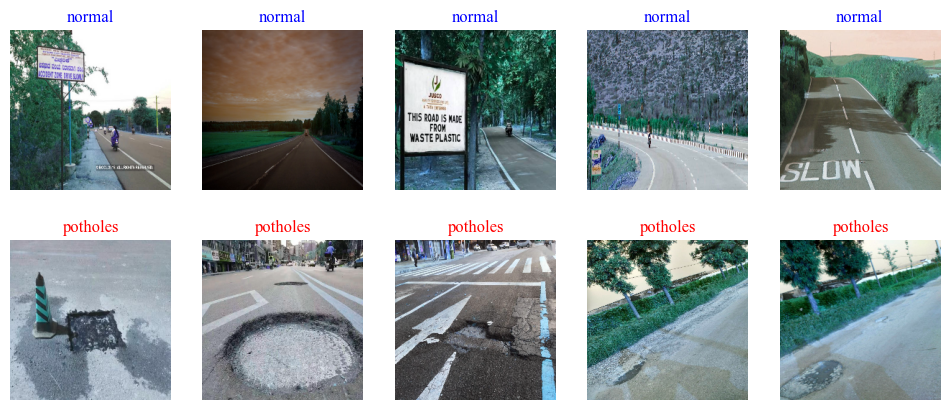

In [9]:
def plot_img(inputImgNew, inputLabelNew):
    plt.figure(figsize = (12, 5))
    i=1
    for image,label in zip(inputImgNew,inputLabelNew):
        if i<=5:
            if label == 1:
                plt.subplot(2,5,i)
                plt.imshow(image)
                plt.title('normal',fontname='Times New Roman', fontsize=12, color='blue')
                plt.axis('off')
                i += 1
        elif 5<i<11:
            if label == 0:
                plt.subplot(2,5,i)
                plt.imshow(image)
                plt.title('potholes',fontname='Times New Roman', fontsize=12, color='red')
                plt.axis('off')
                i += 1
        else:
            break
    plt.savefig('Figures\\PCA-SVM训练样本.pdf',bbox_inches='tight')

     
plot_img(inputImgNew, inputLabelNew)

In [10]:
nx, ny, nz = train_x.shape[1], train_x.shape[2], train_x.shape[3]
train_x_nn, test_x_nn = inputImgNew, test_x
train_x = inputImgNew.reshape((inputImgNew.shape[0], nx * ny * nz)) / 255
test_x = test_x.reshape((test_x.shape[0], nx * ny * nz)) / 255
train_y = inputLabelNew.reshape((inputLabelNew.shape[0], 1)) 
test_y = test_y.reshape((test_y.shape[0], 1)) 

In [11]:
im_pca = PCA()
im_pca.fit(train_x)
variance_explained_list = im_pca.explained_variance_ratio_.cumsum()

In [12]:
test_x_pca = im_pca.transform(test_x)
train_x_pca = im_pca.transform(train_x)

In [13]:
# SVM网格调优
def svm_grid_search(C, kernel, train_x, train_y):
    accuracy_score_list = []
    
    for c in C:
        svmClassifier = svm.SVC(C = c, kernel = kernel)
        svmClassifier.fit(train_x, train_y.ravel())
        pred_y = svmClassifier.predict(train_x)
        accuracy = accuracy_score(train_y, pred_y)
        accuracy_score_list.append(accuracy)
        print('Regularization parameters: {:.2f}，Accuracy：{:.4f}'.format(c, accuracy))
    
    max_accurarcy_id = accuracy_score_list.index(max(accuracy_score_list))
    return C[max_accurarcy_id] 

C, kernel = [0.1 * i for i in range(1, 30)], 'rbf'
opt_C = svm_grid_search(C, kernel, train_x_pca, train_y)

Regularization parameters: 0.10，Accuracy：0.8625
Regularization parameters: 0.20，Accuracy：0.8625
Regularization parameters: 0.30，Accuracy：0.8865
Regularization parameters: 0.40，Accuracy：0.9219
Regularization parameters: 0.50，Accuracy：0.9448
Regularization parameters: 0.60，Accuracy：0.9667
Regularization parameters: 0.70，Accuracy：0.9802
Regularization parameters: 0.80，Accuracy：0.9875
Regularization parameters: 0.90，Accuracy：0.9927
Regularization parameters: 1.00，Accuracy：0.9958
Regularization parameters: 1.10，Accuracy：0.9969
Regularization parameters: 1.20，Accuracy：0.9979
Regularization parameters: 1.30，Accuracy：0.9990
Regularization parameters: 1.40，Accuracy：0.9990
Regularization parameters: 1.50，Accuracy：1.0000
Regularization parameters: 1.60，Accuracy：1.0000
Regularization parameters: 1.70，Accuracy：1.0000
Regularization parameters: 1.80，Accuracy：1.0000
Regularization parameters: 1.90，Accuracy：1.0000
Regularization parameters: 2.00，Accuracy：1.0000
Regularization parameters: 2.10，Accuracy

In [14]:
svmClassifier = svm.SVC(C = opt_C, kernel = 'rbf')
svmClassifier.fit(train_x_pca, train_y.ravel())
pred_y = svmClassifier.predict(test_x_pca)
accuracy = accuracy_score(test_y, pred_y)
print('Test Accuracy: {:2.2f}%'.format(accuracy*100))

Test Accuracy: 86.67%


In [15]:
# 分类报告
from sklearn.metrics import classification_report
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

           0       0.50      0.25      0.33         8
           1       0.89      0.96      0.93        52

    accuracy                           0.87        60
   macro avg       0.70      0.61      0.63        60
weighted avg       0.84      0.87      0.85        60


In [16]:
# 保存模型
import pickle
with open('Models\\PCA.pkl', 'wb') as f:
    pickle.dump(im_pca, f)
f.close()
with open('Models\\PCA-SVM.pkl', 'wb') as f:
    pickle.dump(svmClassifier, f)
f.close()